# Basic Data analyses

## Load in the data

In [25]:
import numpy as np, sys, scipy.stats, pandas as pd, os, os.path, csv, PythonAnalyses

import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
pd.options.display.mpl_style = 'default'

Start = 1 #if I want to reload data from csvs = 1. If i want to load python pickle == 0

filename = 'AdditionalSingleton_TargetUncertain_Freq.csv'
csvName = 'AdditionalSingleton_TargetUncertain_Freq'

if sys.platform == 'linux2': #is this my linux laptop
    path = '/home/dan/Dropbox/TargetUncertainty/Exp4'
elif sys.platform == 'darwin': #is this my mac work comp    
    path = '/Users/danvatterott/Dropbox Encore/Dropbox/TargetUncertainty/Exp4/'

os.chdir(path)

if Start == 1: #load in data from csv
    numfiles = len([name for name in os.listdir('.') if os.path.isfile(name) and name.endswith(".csv") and name[0].isdigit()])
    for partnum in xrange(1,numfiles+1): #this is a loop that goes through all participants
        filename = '%s_' % str(partnum) + csvName + '.csv'
        if partnum == 1: 
            df = pd.read_csv(filename)
        if partnum > 1: 
            df = df.append(pd.read_csv(filename))
    df.columns = map(str.lstrip, df.columns)
    df.to_pickle(csvName+'.pkl') #save this data frame all together
elif Start == 0: #load the data from a previously saved python file. should save time if not adding csv data. 
    df = pd.read_pickle(csvName+'.pkl')

In [26]:
df[0:3] #take a quick look at the dataframe. 

,TarType,TarLoc,TarColorCode,DistCond,TarDistDist,DistLoc,DistLine,Resp,Block,ColorFreq,ChangeCounter,Acc,RT,Sub#
0,2,1,4,2,2,3,2,0,0,1,0,0,2000.0000,1
1,2,2,2,1,0,0,0,3,0,2,0,0,350.4923,1
2,2,6,4,1,0,0,0,1,0,1,0,0,616.6495,1


SingletonCueMatch = 1 = color singleton at cued location/object
SingletonCueMatch = 2 = color singleton at uncued location/object
SingletonCueMatch = 0 = color singleton absent
BlockType = 1 = cross
BlockType = 2 = circle
BlockType = 3 = cardinal
BlockType = 4 = diagonal

## Data Trimming

data trimming. correct, slower than 300 ms and faster than 1500. 

In [27]:
Trimmer = df['Block'] > 0 #not the practice block
Trimmer2 = df['Acc'] == 1 #not an error trial
Trimmer3 = df['RT'] > 300 #not a super fast response
PartTrim = (df['Sub#'] != 66)

DistCond = df[Trimmer & Trimmer2 & Trimmer3].groupby(['DistCond','Sub#']) 
RTTrim = DistCond['RT'].mean() + 2.5*DistCond['RT'].std(ddof=0)
subList = df.drop_duplicates(subset='Sub#')
TrimmerOld = [False]*len(df)
for sub in subList['Sub#']: #loop through every subject. 
    TrimmerA = (df.DistCond == 1) & (df['RT'] < RTTrim[1][sub]) & (df['Sub#'] == sub)
    TrimmerB = (df.DistCond == 2) & (df['RT'] < RTTrim[2][sub]) & (df['Sub#'] == sub)
    Trimmer4 = [any(tup) for tup in zip(TrimmerA, TrimmerB, TrimmerOld)] #combine those 2 RT trimmers. 
    TrimmerOld = Trimmer4

In [28]:
totalTrialNum = np.size(df[PartTrim & Trimmer],0)
ex_counter = 0
Total=0
for sub in df['Sub#'].unique(): #loop through every subject. 
    TrimmerA = (df[Trimmer].DistCond == 1) & (df[Trimmer]['RT'] > RTTrim[1][sub]) & (df[Trimmer]['Sub#'] == sub) & (df[Trimmer].Acc==1)
    TrimmerB = (df[Trimmer].DistCond == 2) & (df[Trimmer]['RT'] > RTTrim[2][sub]) & (df[Trimmer]['Sub#'] == sub) & (df[Trimmer].Acc==1)
    TrimmerC = df[Trimmer]['RT'] < 300 & (df[Trimmer].Acc==1)
    Total+= (sum(TrimmerA)+sum(TrimmerB)+sum(TrimmerC))
Total = sum(TrimmerA) + sum(TrimmerB) + sum(TrimmerC)
print Total
print totalTrialNum
Rt_ex = float(Total)/float(totalTrialNum)
print '%.9f' % Rt_ex
#measuring how many trials are excluded. 

34
7680
0.004427083


checking acc. looks good. everyone above 90%

In [29]:
tableAcc = df[Trimmer].pivot_table(values='Acc', index='Sub#', aggfunc=np.mean)
tableAcc

Sub#
1    0.959375
2    0.878125
3    0.950000
4    0.981250
5    0.917708
6    0.918750
7    0.981250
8    0.922917
Name: Acc, dtype: float64

In [30]:
tableRT = df[Trimmer & Trimmer2 & Trimmer3 & Trimmer4].pivot_table(values='RT', index='Sub#', aggfunc=np.mean)
tableRT

Sub#
1    850.898361
2    614.358924
3    670.047412
4    645.053529
5    714.054194
6    804.324221
7    706.499745
8    639.071922
Name: RT, dtype: float64

## RT Data

In [31]:
DTRIM = df['DistCond'] == 1
tableRT2A = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM].pivot_table(values='RT', index='Sub#', columns=['ColorFreq'], aggfunc=np.mean)
DTRIM = df['DistCond'] == 2
tableRT2B = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM].pivot_table(values='RT', index='Sub#', columns=['ColorFreq'], aggfunc=np.mean)

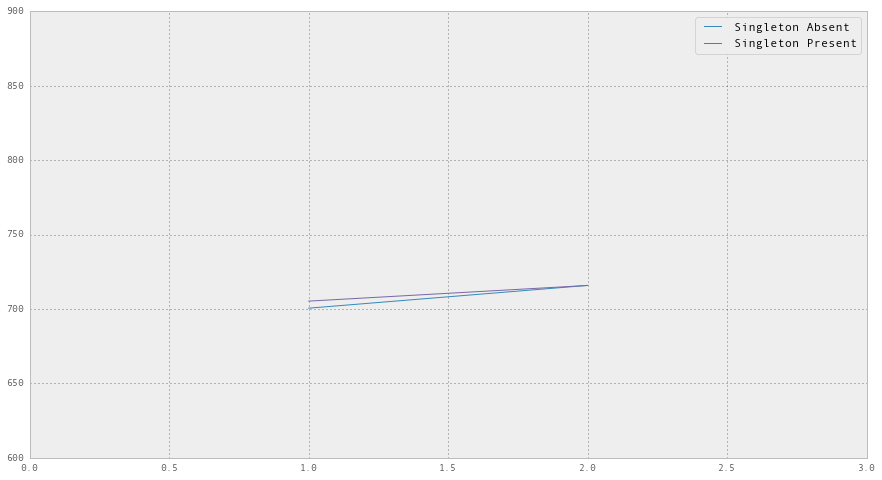

In [32]:
xdata = df['ColorFreq'][PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4].unique()

Absent  = np.mean(tableRT2A)
Present = np.mean(tableRT2B)

fig = plt.figure(figsize=(15,8))
axes = fig.add_subplot(111)

axes.plot(xdata, Absent, label='Singleton Absent'); 
axes.plot(xdata, Present, label='Singleton Present')
axes.legend()
axes.set_ylim(600,900)
axes.set_xlim(0,3);

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			862.45			825.76			
2			605.87			621.91			
3			657.69			680.57			
4			639.63			641.01			
5			712.17			713.66			
6			788.72			805.58			
7			712.63			700.24			
8			625.3			653.67			
mean			700.56			705.3			
STE			31.18			26.4			
----------------------------------------------------------------------------------------------------
ttest = (-0.62813545453384934, 0.54985118011569645)
n = 8


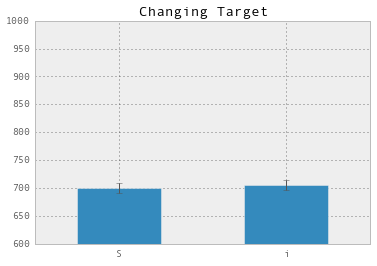

In [33]:
ConType = df['ColorFreq'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			870.44			884.31			
2			598.66			632.69			
3			655.06			690.52			
4			671.03			657.42			
5			714.52			722.99			
6			869.04			797.57			
7			692.76			721.18			
8			655.33			619.92			
mean			715.86			715.83			
STE			35.61			31.43			
----------------------------------------------------------------------------------------------------
ttest = (0.0023279741346843245, 0.99820750157113358)
n = 8


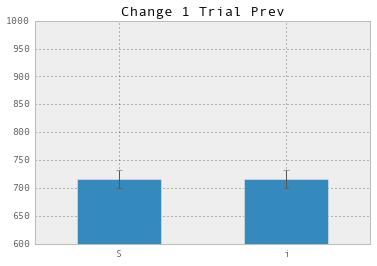

In [34]:
ConType = df['ColorFreq'] == 2
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Change 1 Trial Prev')

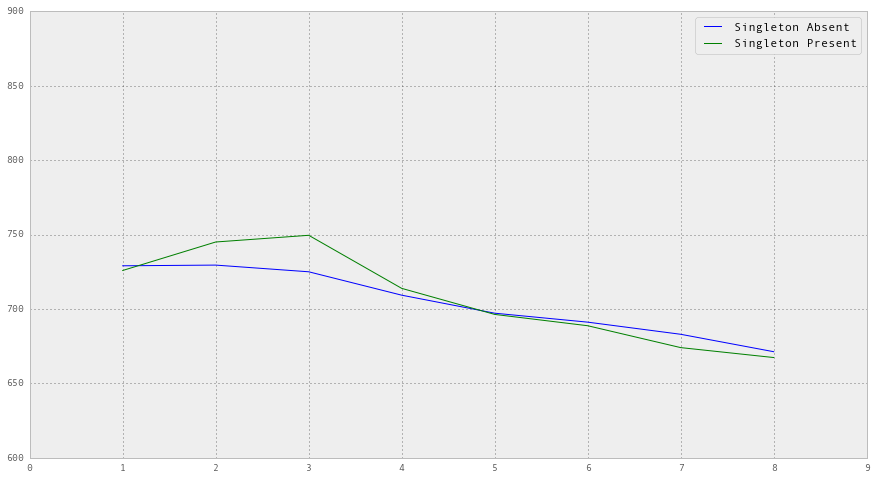

In [35]:
tableRT2 = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4].pivot_table(values='RT', index='Block', columns=['DistCond'], aggfunc=np.mean)

xdata = df['Block'][PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4].unique()
Absent  = tableRT2[1]
Present = tableRT2[2]

fig = plt.figure(figsize=(15,8))
axes = fig.add_subplot(111)

axes.plot(xdata, Absent, 'blue', label='Singleton Absent'); 
axes.plot(xdata, Present, 'green', label='Singleton Present')
axes.legend()
axes.set_ylim(600,900)
axes.set_xlim(0,9);

In [40]:
df['Col_prevTrial'] = df['ColorFreq'].shift(periods=1)

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			861.26			812.77			
2			605.8			625.93			
3			654.16			680.57			
4			644.1			643.74			
5			705.89			713.07			
6			792.27			806.84			
7			707.5			701.18			
8			623.06			646.59			
mean			699.25			703.84			
STE			31.23			25.38			
----------------------------------------------------------------------------------------------------
ttest = (-0.53290604839900646, 0.6105908544428964)
n = 8


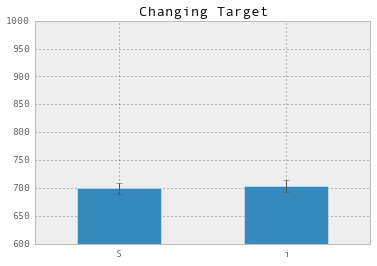

In [41]:
ConType = df['ColorFreq'] == 1
ConType2 = df['Col_prevTrial'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & ConType2].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			881.8			881.03			
2			588.1			625.64			
3			659.28			692.76			
4			669.67			669.84			
5			701.49			716.68			
6			875.21			800.97			
7			689.99			714.93			
8			651.24			620.46			
mean			714.6			715.29			
STE			37.71			31.17			
----------------------------------------------------------------------------------------------------
ttest = (-0.052276429643544876, 0.9597689834289973)
n = 8


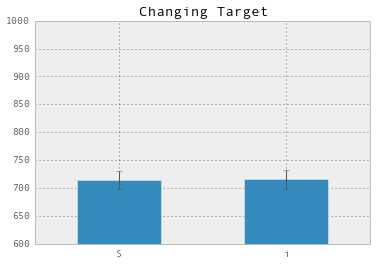

In [42]:
ConType = df['ColorFreq'] == 2
ConType2 = df['Col_prevTrial'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & ConType2].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			867.22			876.8			
2			606.14			604.79			
3			672.06			680.57			
4			622.81			630.23			
5			738.14			715.84			
6			774.17			800.98			
7			734.93			696.52			
8			633.86			680.18			
mean			706.17			710.74			
STE			31.55			31.48			
----------------------------------------------------------------------------------------------------
ttest = (-0.48898503012749578, 0.63980005222491743)
n = 8


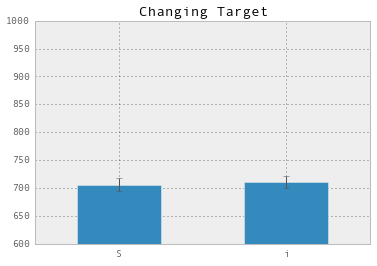

In [43]:
ConType = df['ColorFreq'] == 1
ConType2 = df['Col_prevTrial'] == 2
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & ConType2].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			824.4			897.84			
2			652.34			661.75			
3			639.94			679.74			
4			676.27			597.78			
5			757.53			774.19			
6			802.09			786.86			
7			702.16			739.92			
8			676.66			617.09			
mean			716.42			719.4			
STE			24.66			35.35			
----------------------------------------------------------------------------------------------------
ttest = (-0.16287376179827504, 0.87522009299156978)
n = 8


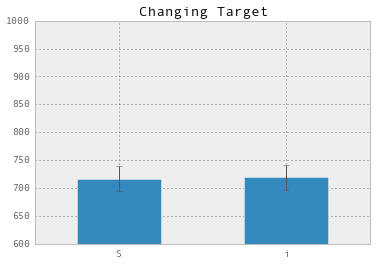

In [44]:
ConType = df['ColorFreq'] == 2
ConType2 = df['Col_prevTrial'] == 2
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & ConType2].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')